## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf
#自動增長 GPU 記憶體用量的方式，讓程式需要多少記憶體就拿多少
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], BATCH_SIZE=1024):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE_EXP = [2, 16, 32, 128, 256]
MOMENTUM = 0.95

In [7]:
results = {}
"""
使用迴圈建立不同的帶不同  Batch_size 的模型並訓練
"""
for BATCH_SIZE in BATCH_SIZE_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with BATCH_SIZE = %f" % (BATCH_SIZE))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "BATCH_SIZEt_EXP-%s" % str(BATCH_SIZE)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

W0724 20:25:06.969400 16052 deprecation_wrapper.py:119] From C:\Users\pablo\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0724 20:25:06.970428 16052 deprecation_wrapper.py:119] From C:\Users\pablo\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0724 20:25:06.973403 16052 deprecation_wrapper.py:119] From C:\Users\pablo\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0724 20:25:06.973403 16052 deprecation_wrapper.py:119] From C:\Users\pablo\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0724 20:25:06.975385 16052 

Experiment with BATCH_SIZE = 2.000000


W0724 20:25:07.219760 16052 deprecation_wrapper.py:119] From C:\Users\pablo\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0724 20:25:07.288547 16052 deprecation.py:323] From C:\Users\pablo\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

50000/50000 [==============================] - 179s 4ms/step - loss: 2.2531 - acc: 0.1561 - val_loss: 3.6907 - val_acc: 0.2032
Epoch 50/50
50000/50000 [==============================] - 182s 4ms/step - loss: 2.2481 - acc: 0.1561 - val_loss: 3.7815 - val_acc: 0.1825
Experiment with BATCH_SIZE = 16.000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None,

50000/50000 [==============================] - 23s 461us/step - loss: 1.1069 - acc: 0.6063 - val_loss: 1.3390 - val_acc: 0.5328
Epoch 48/50
50000/50000 [==============================] - 22s 448us/step - loss: 1.1023 - acc: 0.6077 - val_loss: 1.3558 - val_acc: 0.5255
Epoch 49/50
50000/50000 [==============================] - 23s 451us/step - loss: 1.1039 - acc: 0.6057 - val_loss: 1.3896 - val_acc: 0.5168
Epoch 50/50
50000/50000 [==============================] - 22s 445us/step - loss: 1.0976 - acc: 0.6099 - val_loss: 1.4031 - val_acc: 0.5212
Experiment with BATCH_SIZE = 32.000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalizati

50000/50000 [==============================] - 12s 234us/step - loss: 0.8409 - acc: 0.6996 - val_loss: 1.5024 - val_acc: 0.5147
Epoch 46/50
50000/50000 [==============================] - 12s 232us/step - loss: 0.8355 - acc: 0.7017 - val_loss: 1.6141 - val_acc: 0.4929
Epoch 47/50
50000/50000 [==============================] - 11s 230us/step - loss: 0.8190 - acc: 0.7074 - val_loss: 1.5567 - val_acc: 0.5093
Epoch 48/50
50000/50000 [==============================] - 11s 230us/step - loss: 0.8084 - acc: 0.7117 - val_loss: 1.6278 - val_acc: 0.4993
Epoch 49/50
50000/50000 [==============================] - 11s 230us/step - loss: 0.8101 - acc: 0.7110 - val_loss: 1.6103 - val_acc: 0.5068
Epoch 50/50
50000/50000 [==============================] - 12s 233us/step - loss: 0.7999 - acc: 0.7155 - val_loss: 1.6110 - val_acc: 0.5030
Experiment with BATCH_SIZE = 128.000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   


50000/50000 [==============================] - 4s 85us/step - loss: 0.3401 - acc: 0.8820 - val_loss: 2.3061 - val_acc: 0.4617
Epoch 44/50
50000/50000 [==============================] - 4s 85us/step - loss: 0.3278 - acc: 0.8864 - val_loss: 2.3503 - val_acc: 0.4512
Epoch 45/50
50000/50000 [==============================] - 4s 83us/step - loss: 0.3202 - acc: 0.8889 - val_loss: 2.4805 - val_acc: 0.4383
Epoch 46/50
50000/50000 [==============================] - 4s 84us/step - loss: 0.3038 - acc: 0.8966 - val_loss: 2.4800 - val_acc: 0.4661
Epoch 47/50
50000/50000 [==============================] - 4s 84us/step - loss: 0.2950 - acc: 0.8989 - val_loss: 2.3691 - val_acc: 0.4752
Epoch 48/50
50000/50000 [==============================] - 4s 84us/step - loss: 0.2797 - acc: 0.9052 - val_loss: 2.3680 - val_acc: 0.4799
Epoch 49/50
50000/50000 [==============================] - 4s 84us/step - loss: 0.2618 - acc: 0.9113 - val_loss: 2.4696 - val_acc: 0.4725
Epoch 50/50
50000/50000 [=====================

Epoch 42/50
50000/50000 [==============================] - 3s 58us/step - loss: 0.2675 - acc: 0.9201 - val_loss: 2.1731 - val_acc: 0.4738
Epoch 43/50
50000/50000 [==============================] - 3s 58us/step - loss: 0.2440 - acc: 0.9273 - val_loss: 2.3147 - val_acc: 0.4588
Epoch 44/50
50000/50000 [==============================] - 3s 58us/step - loss: 0.2295 - acc: 0.9341 - val_loss: 2.4842 - val_acc: 0.4557
Epoch 45/50
50000/50000 [==============================] - 3s 59us/step - loss: 0.2252 - acc: 0.9343 - val_loss: 2.3270 - val_acc: 0.4608
Epoch 46/50
50000/50000 [==============================] - 3s 59us/step - loss: 0.2107 - acc: 0.9394 - val_loss: 2.3331 - val_acc: 0.4751
Epoch 47/50
50000/50000 [==============================] - 3s 58us/step - loss: 0.1968 - acc: 0.9463 - val_loss: 2.3919 - val_acc: 0.4603
Epoch 48/50
50000/50000 [==============================] - 3s 58us/step - loss: 0.1905 - acc: 0.9473 - val_loss: 2.4006 - val_acc: 0.4658
Epoch 49/50
50000/50000 [=========

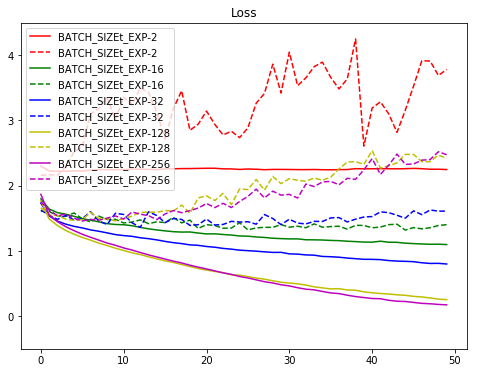

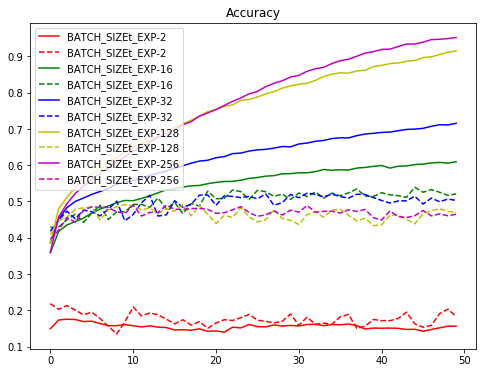

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([-0.5, 4.5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()